In [1]:
# import deps
import PIL.Image
import scipy.cluster
import scipy.spatial
import numpy as np

In [2]:
# open image and save into `points`
with PIL.Image.open("turquoise.png") as image:
    points = np.array(image)/255  # force float
    w, h = points.shape[:2]
    points = points.reshape((w*h, 3)) # [x][y][rgb] -> [i][rgb]
    # remove colors made identical with above dimension drop
    points = np.unique(points, axis=0)

# Yotam's proposed algorithm
Given a set of $N$ points $p_i$ and an outlier percentage $\lambda$, run k-means with $k = \frac N {100 - \lambda}$, and then compute the convex hull $k$ times, leaving out one cluster each time. Return the smallest convex hull.

In [3]:
λ = 5
N = points.shape[0] # not w*h since duplicates were removed
K = int(N / (100 - λ))
K=10
print(f"K = {K}")

K = 10


In [4]:
from IPython.display import clear_output
# create clusters using k-means
clusters = scipy.cluster.vq.kmeans2(points, K)
centroids, labels = clusters
# hide warning if a cluster was empty
clear_output(wait=True)
print(f"centroids: {centroids.shape}")
print(f"labels: {labels.shape}")

centroids: (10, 3)
labels: (61931,)


In [5]:
# create every hull that excludes exactly one cluster
hulls = list()
for label in range(K):
    # exclude the current label (a cluster)
    mask = np.where(labels != label)
    included = points[mask]
    # create convex hull
    hull = scipy.spatial.ConvexHull(included)
    hulls.append((hull, label))

In [6]:
# find the hull that has the smallest volume
smallest_hull, label = min(hulls, key=lambda hull: hull[0].volume)
starting_hull = scipy.spatial.ConvexHull(points)
print(f"volume reduced by {(starting_hull.volume - smallest_hull.volume) / starting_hull.volume * 100:.2f}%")
# `.points` is taken straight from the input
print(f"excluded {len(starting_hull.points) - len(smallest_hull.points)} points")

volume reduced by 19.60%
excluded 5156 points


## Results

Below is a comparison of the output convex hull made using just `points` and the output convex hull made by finding one of $k$ clusters whose removal minimizes the volume of the hull.

In [7]:
import matplotlib.pyplot as plot

### Results: No Manipulation

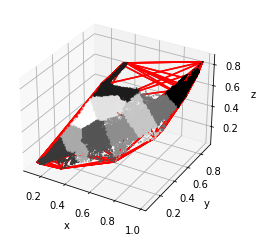

In [8]:
%matplotlib inline
figure = plot.figure()
axes = figure.add_subplot(111, projection="3d")
axes.scatter(
    points.T[0], 
    points.T[1], 
    points.T[2], 
    c=np.array([labels/(K-1)]*3).T,
    s=1)

for simplex in starting_hull.simplices:
    simplex = np.append(simplex, simplex[0])
    axes.plot(
        points[simplex, 0], 
        points[simplex, 1], 
        points[simplex, 2],
        "r-")
    
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_zlabel("z")

plot.savefig("out/before.png", transparent=False, dpi=300)
plot.show()

### Results: With Manipulation

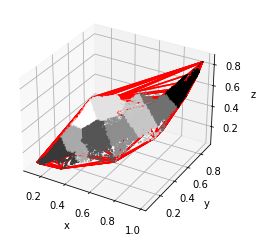

In [9]:
%matplotlib inline
figure = plot.figure()
axes = figure.add_subplot(111, projection="3d")
mask = np.where(labels != label)
axes.scatter(
    points[mask].T[0], 
    points[mask].T[1], 
    points[mask].T[2], 
    c=np.array([labels[mask]/(K-1)]*3).T,
    s=1)

for simplex in smallest_hull.simplices:
    simplex = np.append(simplex, simplex[0])
    axes.plot(
        points[mask][simplex, 0], 
        points[mask][simplex, 1], 
        points[mask][simplex, 2],
        "r-")
    
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_zlabel("z")

plot.savefig("out/after.png", transparent=False, dpi=300)
plot.show()

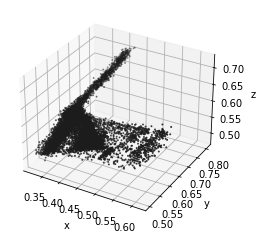

In [10]:
%matplotlib inline
# indices = np.arange(points.shape[0]); masked = set(mask[0])
# inverted_mask = np.fromiter((i for i in indices if i not in masked), dtype=np.uint)
excluded = points[np.where(labels == label)]

figure = plot.figure()
axes = figure.add_subplot(111, projection="3d")
axes.scatter(
    excluded.T[0], 
    excluded.T[1], 
    excluded.T[2], 
    c=np.array([labels[np.where(labels == label)]/(K-1)]*3).T,
    s=1)

axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_zlabel("z")

plot.savefig("out/excluded.png", transparent=False, dpi=300)
plot.show()